In [1]:
from brian2 import *
%matplotlib inline

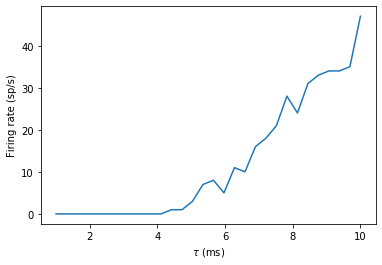

In [2]:
start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
output_rates = []   # Use this list to store output rates
# Iterate over range of time constants
for tau in tau_range:
    # Construct the network each time
    P = PoissonGroup(num_inputs, rates=input_rate)
    eqs = '''
    dv/dt = -v/tau : 1
    '''
    G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
    S = Synapses(P, G, on_pre='v += weight')
    S.connect()
    M = SpikeMonitor(G)
    # Run it and store the output firing rate in the list
    run(1*second)
    output_rates.append(M.num_spikes/second)
# And plot it
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

In [3]:
#a little slow to run!because for each loop, you’re recreating the objects from scratch. We can improve:
# using store and restore

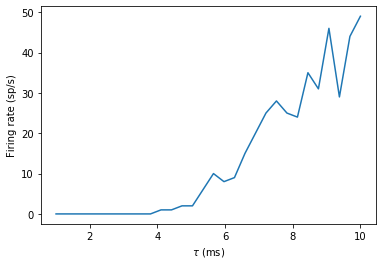

In [4]:
start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
output_rates = []
# Construct the network just once
P = PoissonGroup(num_inputs, rates=input_rate)
eqs = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
S = Synapses(P, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Store the current state of the network
store()
for tau in tau_range:
    # Restore the original state of the network
    restore()
    # Run it with the new value of tau
    run(1*second)
    output_rates.append(M.num_spikes/second)
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');


In [6]:
#The noise is coming from the fact that we run the Poisson group afresh each time.
#If we only wanted to see the effect of the time constant, we could make sure that the spikes were the same
# We do this by running just the Poisson group once, recording its spikes, and creating a new SpikeGeneratorGroup 

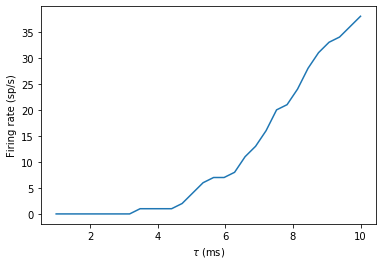

In [7]:
start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
output_rates = []
# Construct the Poisson spikes just once
P = PoissonGroup(num_inputs, rates=input_rate)
MP = SpikeMonitor(P)
# We use a Network object because later on we don't
# want to include these objects
net = Network(P, MP)
net.run(1*second)
# And keep a copy of those spikes
spikes_i = MP.i
spikes_t = MP.t
# Now construct the network that we run each time
# SpikeGeneratorGroup gets the spikes that we created before
SGG = SpikeGeneratorGroup(num_inputs, spikes_i, spikes_t)
eqs = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
S = Synapses(SGG, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Store the current state of the network
net = Network(SGG, G, S, M)
net.store()
for tau in tau_range:
    # Restore the original state of the network
    net.restore()
    # Run it with the new value of tau
    net.run(1*second)
    output_rates.append(M.num_spikes/second)
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');


In [8]:
#now there is much less noise and it increases monotonically because the input spikes are the same each time
#meaning we’re seeing the effect of the time constant, not the random spikes.

WARNING    "tau" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


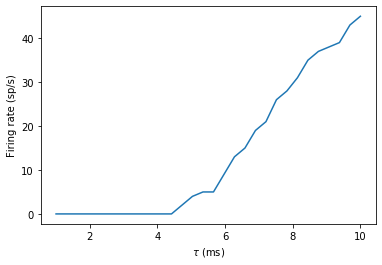

In [9]:
#duplicate that output neuron and make the time constant a parameter of the group.
start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
num_tau = len(tau_range)
P = PoissonGroup(num_inputs, rates=input_rate)
# We make tau a parameter of the group
eqs = '''
dv/dt = -v/tau : 1
tau : second
'''
# And we have num_tau output neurons, each with a different tau
G = NeuronGroup(num_tau, eqs, threshold='v>1', reset='v=0', method='exact')
G.tau = tau_range
S = Synapses(P, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Now we can just run once with no loop
run(1*second)
output_rates = M.count/second # firing rate is count/duration
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

In [10]:
#this is much faster again!

In [11]:
# how the mean and standard deviation of the interspike intervals depends on the time constant.

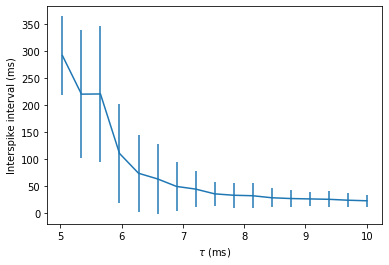

In [12]:
trains = M.spike_trains()
isi_mu = full(num_tau, nan)*second
isi_std = full(num_tau, nan)*second
for idx in range(num_tau):
    train = diff(trains[idx])
    if len(train)>1:
        isi_mu[idx] = mean(train)
        isi_std[idx] = std(train)
errorbar(tau_range/ms, isi_mu/ms, yerr=isi_std/ms)
xlabel(r'$\tau$ (ms)')
ylabel('Interspike interval (ms)');


In [13]:
#spike_trains() is a dictionary with keys being the indices of the neurons and values being the array of spike times for that neuron.